In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pathlib

import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import seaborn as sns
from IPython.display import HTML

import src

In [3]:
%aimport src.visualization.clouds

In [4]:
data_dir = pathlib.Path("../../data").resolve()

data_paths = {
    "lysva": data_dir / "raw" / "lysva",
    "trees": data_dir / "raw" / "trees",
}

In [5]:
lysva_field_survey = gpd.read_file(data_paths["lysva"] / "field_survey.geojson")
lysva_als_files = sorted((data_paths["lysva"] / "als").glob("*.las"))

In [6]:
#| include: true
#| label: tbl-inventory-example
#| tbl-cap: Abc abcs

display(HTML(lysva_field_survey.sample(5).to_html(index=False)))

plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
10.0,524.0,Fir,22.8,24.7,23.75,NaN,NaN,0.0,None,POINT (546576.237 6449102.09)
10.0,46.0,Tilia,15.4,15.4,15.40,NaN,NaN,80.0,None,POINT (546569.62 6449138.901)
9.0,255.0,Birch,15.8,18.1,16.95,NaN,NaN,0.0,None,POINT (546208.845 6449136.643)
10.0,442.0,Tilia,22.1,23.0,22.55,NaN,NaN,0.0,None,POINT (546605.233 6449120.3)
2.0,266.0,Fir,24.8,24.3,24.55,NaN,NaN,0.0,None,POINT (546992.246 6450032.347)


In [7]:
xyz = laspy.read(lysva_als_files[9]).xyz

with rasterio.open(data_paths["lysva"] / "ortho" / "plot_10.tif") as dd:
    colors = np.stack([c for c in dd.sample(xyz[:, :2])])

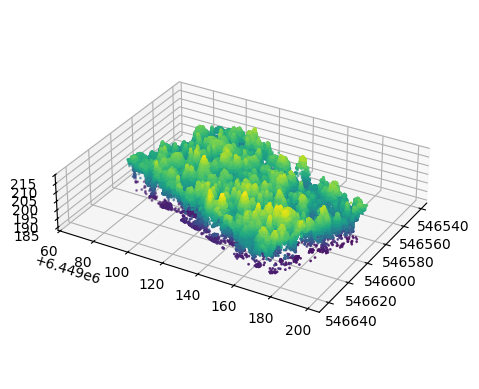

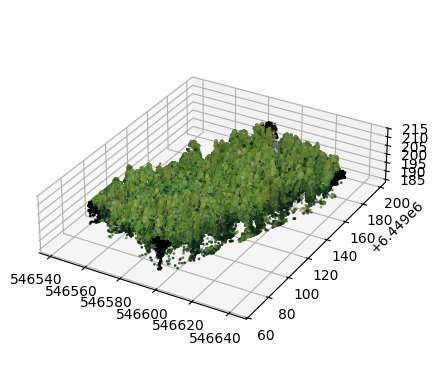

In [8]:
#| include: true
#| label: fig-example-3d-point-cloud
#| layout-ncol: 2
#| fig-cap: This is a caption of this figure.
#| fig-subcap:
#|   - Abc
#|   - Def

params = {
    "azim": 30,
}

ax = src.visualization.clouds.scatter_point_cloud_3d(xyz, **params)
src.visualization.clouds.scatter_point_cloud_3d(xyz, color=colors / 255);

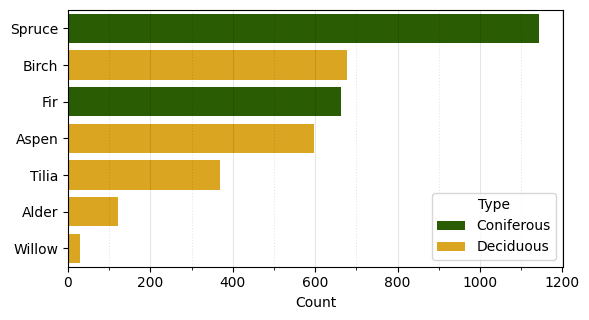

In [9]:
#| include: true
#| label: fig-lysva-species-distribution
#| fig-cap: Distribution of species in the Lysva dataset.

conifiers = {"Spruce", "Fir", "Pine"}

counts = (
    lysva_field_survey.query("species not in ['Elm', 'Pine']")
    .value_counts("species")
    .reset_index()
)
counts["Type"] = counts["species"].map(
    lambda x: "Coniferous" if x in conifiers else "Deciduous"
)

fig, ax = plt.subplots(figsize=(6, 3.3), tight_layout=True)
ax = sns.barplot(
    data=counts,
    x="count",
    y="species",
    hue="Type",
    dodge=False,
    hue_order=["Coniferous", "Deciduous"],
    palette=["#2A5C03", "#DAA520"],
    saturation=1,
    ax=ax,
)
# ax.set_title("Species distribution in the dataset")
ax.set_xlabel("Count")
ax.set_ylabel(None)
ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
ax.grid(axis="x", color="black", alpha=0.1)
ax.grid(which="minor", axis="x", color="black", alpha=0.1, ls=":")